# Deep-Q-Learning

In this notebook I explore the concepts of Deep-Q-Learning by following the papers published DeepMind [V. Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf) and [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/).

As I'm intrigued by the topic of autonomous driving, the [MIT lecture videos by Lex Fridman](https://deeplearning.mit.edu/) introduced me to the topic of DQL motivated me to take a deep dive and get familiar with its concepts.

### !!!This is still a work in progress!!!

In [146]:
import gym
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense

import typing

import matplotlib.pyplot as plt

## Preview of the game

Use **left** and **right arrows** to move the spaceship sideways and the **space bar** to use the main cannon and shoot the aliens!

If you want to move to the left/right and shoot simultaneously then use **s/d**.

As you play, the `PlayPlot` function (marked deprecated) will plot the immediate award for the actions you take. For this uncomment the callback call in the `play` function. 

In [3]:
import pygame
from gym.utils.play import play, PlayPlot

def compute_metrics(obs_t, obs_tp, action, reward, terminated, truncated, info):
    return [reward, np.linalg.norm(action)]

plotter = PlayPlot(
    compute_metrics,
    horizon_timesteps=200,
    plot_names=["Immediate Rew.", "Action Magnitude"]
)

my_env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
mapping = {(pygame.K_SPACE,): 1, (pygame.K_RIGHT,): 2, (pygame.K_LEFT,): 3, (pygame.K_d,): 4, (pygame.K_s,): 5}
play(my_env, keys_to_action=mapping) #, callback=plotter.callback)

/home/hare/.local/lib/python3.10/site-packages/gym/utils/play.py:322: DeprecationWarning: WARN: `PlayPlot` is marked as deprecated and will be removed in the near future.
  deprecation(
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
ERROR: PlayableGame wrapper works only with rgb_array and rgb_array_list render modes, but your environment render_mode = None.
/home/hare/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## Some random action taken

In [ ]:
import gym
env = gym.make("SpaceInvaders-v4", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    action = choose_action(env, observation, 1)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

## Starting to define some functions

For the first attempt we'll use the architecture of the neural network described on page 6 in [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf).

### Preprocess function $\phi$

Since it will be computationally more demanding working with the raw $210 \times 160$ pixel frames, we'll apply a preprocess function $\phi$ to the frames before forwarding them to the neural network. The preprocess function will do the following
- (will not be done here) for a single frame we take the maximum value for each pixel color value and the previous frame (removes flickering in original paper, but we'll use the `ALE/SpaceInvaders-v5` environment which has a frameskip=5 which removes the flickering of the misiles)
- the frames will be converted from RGB representation into gray-scale
- the frames will be resized to $110 \times 84$ images
- the playing area is cropped out so we have a final $84 \times 84$ frame (this is done in, but I might skip this step in this notebook [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf))
- the last 4 frames from a sequence will be modified as explained and stacked to form a $84 \times 84 \times 4$ input for the agent

So, to preprocess our input for the neuarl network, we'll need a function $\phi$ that will take the previous processed sequence $\phi_t$ and new obtained frame $x_{t+1}$ and combine them to a new processed sequence as follows

$$\phi: \phi_t, x_{t+1} \longrightarrow \phi_{t+1}$$

In [141]:
class Preprocessor:
    """
    Takes care of preprocessing frames for the models.
    """
    
    def __init__(self, height:int=84, width:int=84):
        self.height = height
        self.width = width
        
    
    
    # look up additional annotations to add
        # what does the numpy array consist of
        # what does the tf.tensor consist of, it's shape and type
    def preprocess_frame(self, new_raw_obs: np.ndarray) -> tf.uint8:
        """
        Preprocesses one frame for the model.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
        Returns:
            processed frame with shape (84, 84, 1)
        """
        
        processed_fr = tf.image.rgb_to_grayscale(new_raw_obs)
        processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
        processed_fr = tf.image.resize(processed_fr, [self.height, self.width], method='bilinear')
        processed_fr = tf.cast(processed_fr, tf.uint8)

        return processed_fr
    
    def initialize_state(self, env) -> tf.uint8:
        """
        Initializes the first state of an episode with the first 4 frames.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
        Returns:
            state containing the first four preprocessed frames with shape (84, 84, 4)
        """
        
        actions = [env.action_space.sample() for i in range(4)]
        processed_frames = [self.preprocess_frame(obs) for obs in [env.step(action)[0] for action in actions]]
        
        return tf.concat(processed_frames, axis=-1)
        
    
    def new_state(self, new_raw_obs: np.ndarray, old_state: tf.uint8) -> tf.uint8:
        """
        Creates a news state from an old state and a new raw frame.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
            old_state: old state consisting of four preprocessed previous frames (84, 84, 4)
        Returns:
            new state with shape (84, 84, 4) where the new preprocessed frame was appended to the old 
            state and the oldest preprocessed frame was dropped.
        """
        processed_fr = self.preprocess_frame(new_raw_obs)
        
        return tf.concat([old_state[::, ::, 1:], processed_fr], axis=-1)

### Testing the preprocess function $\phi$

In [143]:
## get some observations to test the preprocess function
## first 45 memory entries are before the game starts

memory_raw_frames = []
memory_processed = []

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
curr_raw_obs, info = env.reset(seed=42)
preprocessed = initialize_state(env, curr_raw_obs)
memory_processed.append(preprocessed)

memory_raw_frames.append(curr_raw_obs)
for _ in range(500):
    action = env.action_space.sample()#choose_action(env, curr_raw_obs, 1)
    new_raw_obs, reward, terminated, truncated, info = env.step(action)
    
    preprocessed = preprocess_input(new_raw_obs, curr_raw_obs, memory_processed[-1])
    memory_processed.append(preprocessed)
    
    curr_raw_obs = new_raw_obs
    
    memory_raw_frames.append(curr_raw_obs)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [147]:
# defining a couple of functions to check the original and processed frames
    # check if the flickering is a problem in consecutive images
    # check if the misiles are seen in the processed images


def plot_raw_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
def plot_processed_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img[::, ::, 2])
    plt.show()

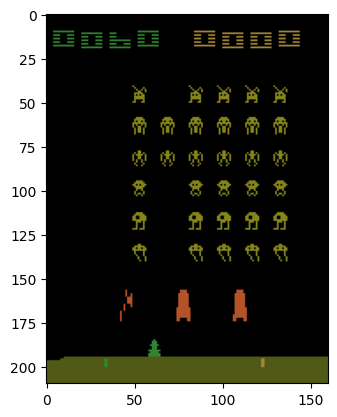

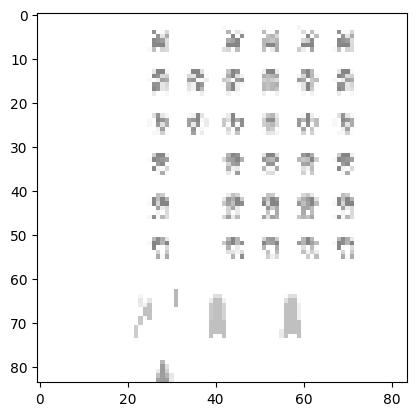

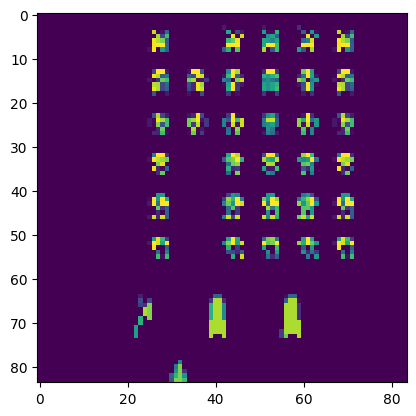

In [145]:
import matplotlib.pyplot as plt

processor = Preprocessor()

imgplot = plt.imshow(memory_raw_frames[286])
plt.show()

old_state = [processor.preprocess_frame(memory_raw_frames[i]) for i in range(282,286)]
old_state = tf.concat(old_state, axis=-1)


processed_frame = processor.preprocess_frame(memory_raw_frames[286])
processed = processor.new_state(memory_raw_frames[290], old_state)

imgplot = plt.imshow(processed)
plt.show()
imgplot = plt.imshow(processed_frame)
plt.show()

### Exploration and exploitation with $\epsilon$-greedy strategy

- explore for rand < eps and exploit for rand > eps
- for first xx amount of frames $\epsilon = 1$
- for the next million frames $\epsilon \rightarrow 0.1$ linearly
- after that it is fixed to $\epsilon = 0.1$

In [148]:
class ExplorationVsExploitation:
    """
        This class handles the epsilon-greedy strategy which will be used to determine whethere
        we will choose an action to explore new possibilites or exploit the accumulated experience.
    """
    def __init__(self,
                 dqn_model,
                 n_actions: int,
                 eps_initial: float =1.0,
                 eps_final: float =0.1,
                 start_fr: int =5000,
                 end_fr: int =1000000):
        """
            Args:
                dqn_model
                n_actions
                eps_initial
                eps_final
                start_fr
                end_fr
        """
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.start_fr = start_fr
        self.end_fr = end_fr
        self.slope = (self.eps_initial - self.eps_final) / (self.start_fr - self.end_fr)
        self.intercept = eps_initial - self.slope * self.start_fr
        
        self.n_actions = n_actions
        
        self.dqn_model = dqn_model
        
        
        
    def __call__ (self, curr_state:tf.uint8, frame_num:int) -> int:
        """
            Args:
                curr_state: Current state of the game which will be used if we opt out for exploitation.
                frame_num: Number of frame which is being processed.
        """
        
        if frame_num <= start_fr:
            eps = self.eps_initial
        elif start_fr < frame_num < end_fr:
            eps = self.slope * frame_num + self.intercept
        elif frame_num >= end_fr:
            eps = self.eps_final
        
        if np.random.rand() < eps:
            # we explore
            return np.random.randint(self.n_actions)
        else:
            # we choose the action yielding the highest reward according to our model
            model_prediction = self.dqn_model.predict(tf.expand_dims(curr_state, axis=0), verbose=0)
            return tf.argmax(action)
    
    
    

### Defining the agent

- define it as a class

In [8]:
def agent (obs_shape, action_shape, learning_rate):
    # define a Sequential CNN using Keras predefined layers
    # Here we'll use the same architecture as in Volodymir Mnih et al (2015)
    
    # need to check if I can use a keras model or I need to define something more custom for DQN
    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(action_shape, activation="linear"))

    model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])        
    
    return model


### Replay memory

The replay memory D stores following information (called *transition*) every step

$$\left( \phi_t, \ a_t, \ r_t, \ \phi_{t+1} \right) \longrightarrow D$$

where
- $\phi_t$ is the preprocessed sequence including the frame at time step $t$
- $a_t$ is the action taken at time step $t$
- $r_t$ is the reward gained at time step $t$ after taking action $a_t$ in state $\phi_t$ $t$
- $\phi_{t+1}$ is the preprocessed sequence including the new state we reached after taking action $a_t$

In [9]:
class replay_memory:
    def __init__(self, capacity, minibatch_size):
        self.capacity = capacity
        self.memories = []
        self.minibatch_size = minibatch_size
        
    def store_transition(self, curr_state, curr_action, reward, new_state, lives):
        # store transition in replay_memory
        self.memories.append([curr_state, curr_action, reward, new_state, lives])
        if (len(self.memories) > self.capacity):
            self.memories.pop(0)
    def sample_minibatch(self):
        # sample a minibatch of transition from replay_memory
        return random.sample(self.memories, self.minibatch_size)
    
    def get_memories(self):
        return self.memories
    
    def get_count_of_memories(self):
        return len(self.memories)

In [10]:
# maybe put this as part of the agent class or leave it like this

def update_step(replay_memory, main_model, target_model):
    # sample minibatch of transitions
    minibatch = replay_memory.sample_minibatch()
    target_q = []
    X = []
    
    # for each transition we need a target value Q
    for (idx, (curr_state, curr_action, reward, new_state, lives)) in enumerate(minibatch):
        X.append(curr_state)
        if lives == 0:
            target_q.append(reward)
        else:
            new_state = tf.expand_dims(new_state, axis=0)
            target_pred = max(target_model.predict(new_state, verbose=0)[0])
            target_pred = np.repeat(target_pred, action_shape)
            target_q.append(reward + discount * target_pred)
            
    # update the weights of the main model with target values Q
    main_model.fit(x=np.array(X), y=np.array(target_q), epochs=1, verbose=2)
    
    
    

In [ ]:
my_env = gym.make("SpaceInvaders-v4",render_mode="rgb_array")
obs_shape = my_env.observation_space.shape
action_shape = my_env.action_space.n

memory_size = 1000
num_of_episodes = 1
minibatch_size = 5 #32
update_target_freq = 5    ## update target NN every 5 parameter updates (steps)
discount = 0.99
action_repeat = 4         ## repeat chosen action 4 times
update_main_freq = 4      ## SGD update main NN after 4 chosen actions
learning_rate = 0.001
grad_mom = 0.95
sq_grad_mom = 0.95
min_sq_grad = 0.01
eps = 0

warm_up = 4

## Training the model with the Deep-Q-learning Algorithm

Training details:
- We will follow [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/) and normalize the positive, neutral and negative rewards to 1, 0, -1 respectively

In [13]:
def normalize_rewards(rew):
    return 1 if rew > 0 else -1 if rew < 0 else 0    

In [17]:
def train_DQL():
    ## initialize replay memory D
    memories = replay_memory(memory_size, minibatch_size)
    
    ## initialize action-value function Q with random weights
    main_model = agent(obs_shape, action_shape, learning_rate)
    
    ## initialize action-value target function with same weights 
    target_model = agent(obs_shape, action_shape, learning_rate)
    target_model.set_weights(main_model.get_weights())
    
    ## initialize epsilon greedy algorightm
    exploit_explore = eps_greedy(my_env, eps)
    
    memory_count = 0
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(num_of_episodes):

        ## initialise sequence s1 = {x1} and preprocessed the sequence
        curr_raw_obs, info = my_env.reset()
        curr_state = initialize_state(my_env, curr_raw_obs)
        
        while (info["lives"] > 0):
            
            ## choose an exploration/explotation action 
            curr_action = exploit_explore.choose_action(curr_state, main_model)
            
            ## take action
            new_raw_obs, reward, terminated, truncated, info = my_env.step(curr_action)

            reward = normalize_rewards(reward)

            ## create new sequence with new frame
            new_state = preprocess_input(new_raw_obs, curr_raw_obs, curr_state)

            ## store new transition
            memories.store_transition(curr_state, curr_action, reward, new_state, info["lives"])
            memory_count +=1
            
            ## perform weights update
            if memories.get_count_of_memories() > 50:
                update_step(memories, main_model, target_model)

            curr_state = new_state
            curr_raw_obs = new_raw_obs
                
        #print(memory_count)
        return 0 # memories.get_memories()
            

In [18]:
train_DQL()

NameError: name 'choose_action' is not defined

<img src="./images/DQL-algorithm-2015.png" alt="dql" width="850"/>